<div style="border:solid blue 2px; padding: 20px"> 

<strong>Reviewer's Introduction</strong>

Hello Michael! 👋 

I'm happy to review your project today.

I will categorize my comments in green, blue or red boxes like this:

<div class="alert alert-success">
    <b>Success:</b> Everything is done successfully.
</div>
<div class="alert alert-warning">
    <b>Remarks:</b> Suggestions for optimizations or improvements.
</div>
<div class="alert alert-danger">
    <b>Needs fixing:</b> This must be fixed for a project to be approved.
</div>

Please don't remove my comments :) If you have any questions or comments, don't hesitate to respond to my comments by creating a box that looks like this: 
<div class="alert alert-info"> <b>Student's comment:</b> Your text here.</div>    
<br>


📌 Here's how to create code for student comments inside a Markdown cell:
    
    
    <div class="alert alert-info">
    <b> Student's comment</b>

    Your text here. 
    </div>

You can find out how to **format text** in a Markdown cell or how to **add links** [here](https://sqlbak.com/blog/jupyter-notebook-markdown-cheatsheet). 


<hr>
Reviewer: Han Lee <br>
</div>




<div style="border: solid blue 2px; padding: 15px; margin: 10px">
	<b>Reviewer's Comments – Iteration 1</b>

Congratulations! 

This project meets all requirements ✅, and is approved. 🎉

I have really enjoyed reviewing this project, especially reading through your comments, which I found insightful for understanding your decision making.

<b>Some notable strengths:</b>  

✔️ Thorough data preparation and feature engineering

✔️ Clear understanding of the importance of stationarity and measures taken to gauge and increase stationarity

✔️ Excellent application of multiple models to optimize metrics

Once again, congratulations on a job well done!
</div>


# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Our dataset has info on the number of taxi orders at airports from March 1st 2018 to August 31st 2018! Looks like almost 27,000 rows of data, so we'll check for missing and duplicate entries next.

In [4]:
df.isnull().sum()

num_orders    0
dtype: int64

In [5]:
df.index.duplicated().sum()

0

In [6]:
df.duplicated().sum()

26415

No missing data and no duplicate timestamps, the duplicated num_orders isn't a concern as many of these timestamps could have the same number of orders. Now we'll check if the dataset is monotonic and then resample it by one hour.

In [7]:
df = df.sort_index()
df.index.is_monotonic

True

In [8]:
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
df.duplicated().sum()

4165

In [10]:
df.index.duplicated().sum()

0

Looks like our data is in chronological order and it's now been resampled by each hour! Quick double check on duplicated data but we should be all good to go.

## Analysis

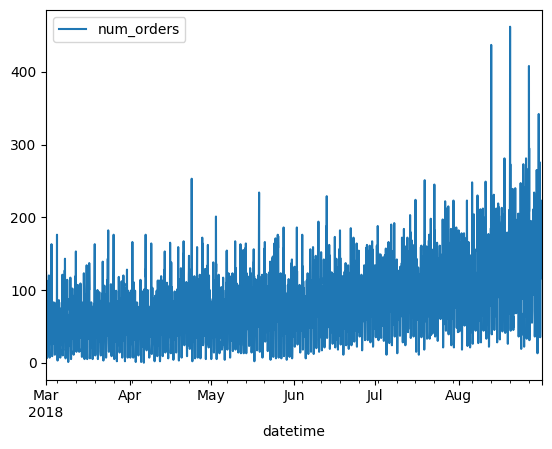

In [11]:
df.plot()
plt.show()

Our baseline graph after resampling, obviously very difficult to make sense of any trends or seasonality in the data, let's see what the rolling mean is like!

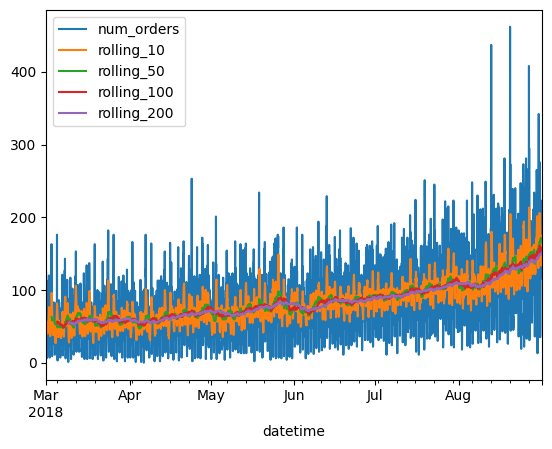

In [12]:
df['rolling_10'] = df['num_orders'].rolling(10).mean()
df['rolling_50'] = df['num_orders'].rolling(50).mean()
df['rolling_100'] = df['num_orders'].rolling(100).mean()
df['rolling_200'] = df['num_orders'].rolling(200).mean()
df[['num_orders', 'rolling_10', 'rolling_50', 'rolling_100', 'rolling_200']].plot()
plt.show()

This graph shows the rolling mean of window size 10, 50, 100, and 200 for the dataset. 10 (orange) appears to be too noisy, while 200 (purple), shows a nice smooth rolling mean. View the plot below with standard deviation included for clarity.

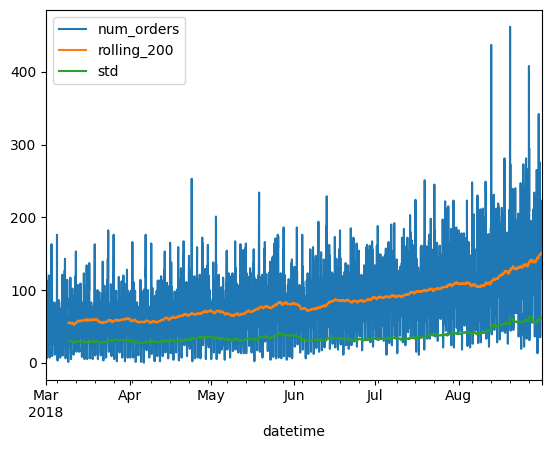

In [13]:
df['std'] = df['num_orders'].rolling(200).std()
df[['num_orders', 'rolling_200', 'std']].plot()
plt.show()

Starting to look like as the summer months come around people are flying more places and ordering more taxis, but let's analyze a bit further to really see what's going on.

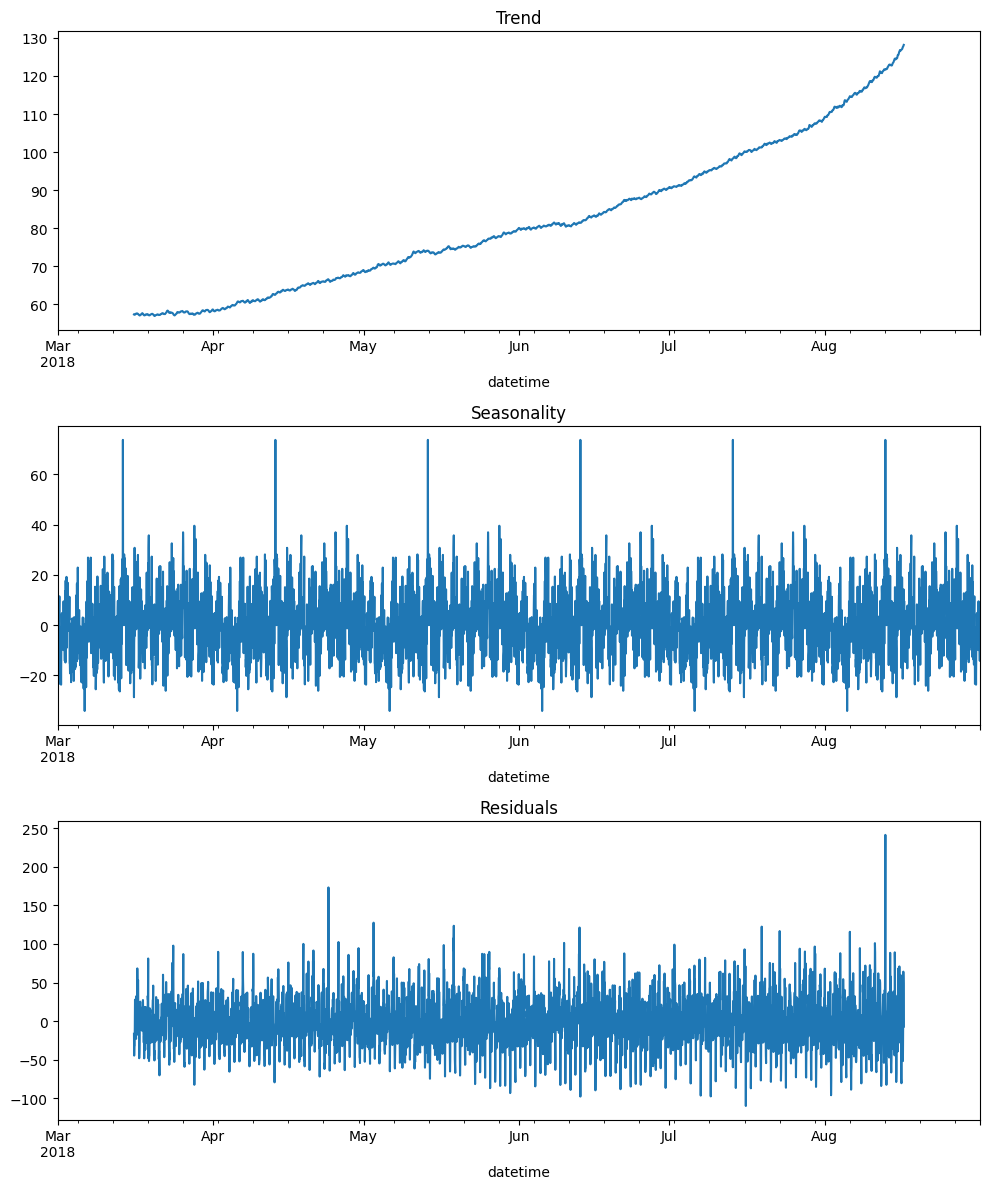

In [14]:
df = df.drop(['rolling_10', 'rolling_50', 'rolling_100', 'rolling_200', 'std'], axis = 1)
decomposed = seasonal_decompose(df, period = 730) #730 hours in a month

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')

plt.tight_layout()

Seasonal data is still a bit messy even when setting the period equal to one month (730 hours), let's zoom in a bit more to see if there's a pattern to be found.

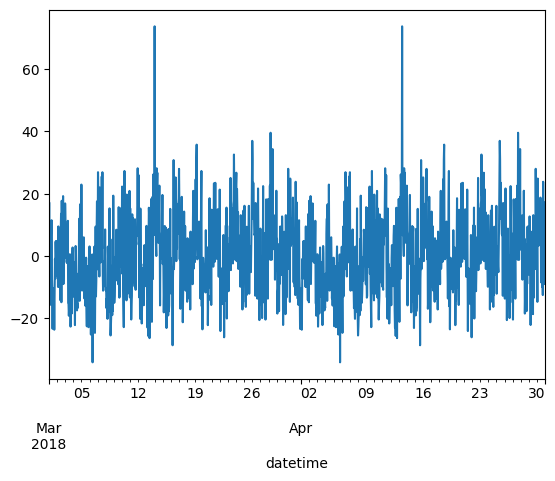

In [15]:
seasonal_slice = decomposed.seasonal['2018-03-01':'2018-04-30']
seasonal_slice.plot()
plt.show()

Looking at just 2 months of data gives a clearer picture that the number of taxi orders at airports seems to spike in the middle of the month and then drop back down very quickly.

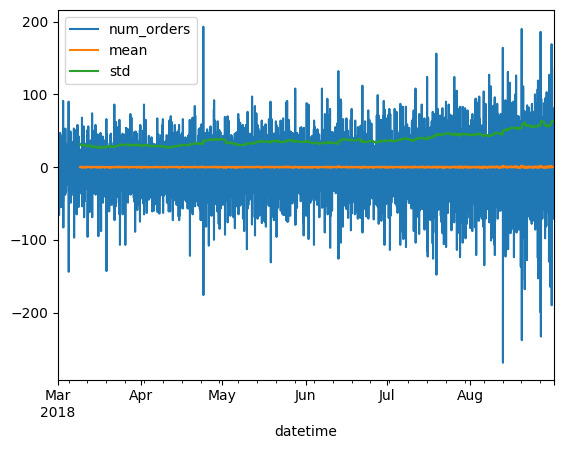

In [16]:
df = df - df.shift(fill_value = 0)
df['mean'] = df['num_orders'].rolling(200).mean()
df['std'] = df['num_orders'].rolling(200).std()
df.plot()
plt.show()

After a quick shift, our data is more stationary and will be easier to forecast!

In [17]:
temp_train, test = train_test_split(df, shuffle = False, test_size = 0.1)
train, val = train_test_split(temp_train, shuffle = False, test_size = 0.1111)

print(train.index.min(), train.index.max())
print(val.index.min(), val.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [18]:
df_stationarityTest = adfuller(train['num_orders'], autolag = 'AIC')
print('P-value: ', df_stationarityTest[1])

P-value:  2.1439174317747356e-30


Confirmed that our dataset has been split into proper training, validation, and test sets! I also did a stationarity test and with a p-value much less than 0.05, we know the time series is already stationary. In model training we'll be able to keep d = 0! Now let's run a quick sanity check before getting into training.

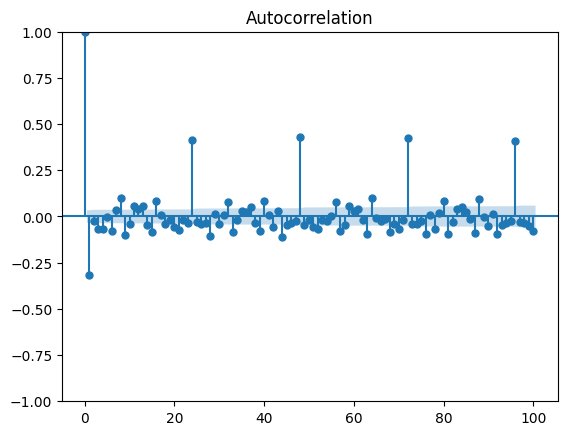

In [19]:
plot_acf(train['num_orders'], lags = 100)
plt.show()

Looking at the ACF graph above, we can see spikes roughly at 1, 24, 48, 72, and 96, leading me to believe there is a strong daily cycle trend in our data.

In [20]:
df_copy = df.copy()

## Training

Our sanity check is going to be using a constant, the median, and root mean squared error (RMSE) as the key metric to compare to our prediction models

In [21]:
%%time

print('Median hourly number of taxi orders:', val['num_orders'].median())
pred_previous = val.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', round(mean_squared_error(val, pred_previous) ** 0.5, 2))

Median hourly number of taxi orders: 2.0
RMSE: 42.95
CPU times: user 2.64 ms, sys: 3.41 ms, total: 6.05 ms
Wall time: 5.07 ms


The goal of our training will be to improve not only over the median model's RMSE values, but train a model well enough that it's RMSE is less than 48!

In [22]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = (df['num_orders'].shift().rolling(rolling_mean_size).mean())

make_features(df, 7, 200)

df.head()

,num_orders,mean,std,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39,NaN,NaN,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14,NaN,NaN,3,1,3,-39.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5,NaN,NaN,3,1,3,-14.0,-39.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23,NaN,NaN,3,1,3,-5.0,-14.0,-39.0,124.0,NaN,NaN,NaN,NaN


### Linear Regression Model

In [23]:
%%time

train = train.dropna()

features_train = train.drop(['num_orders'], axis = 1)
features_val = val.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
target_val = val['num_orders']

model = LinearRegression()
model.fit(features_train, target_train)
train_pred = model.predict(features_train)
val_pred = model.predict(features_val)

print('RMSE on training data:', round(mean_squared_error(target_train, train_pred) ** 0.5, 2))
print('RMSE on validation data:', round(mean_squared_error(target_val, val_pred) ** 0.5, 2))

RMSE on training data: 32.62
RMSE on validation data: 43.58
CPU times: user 7.74 ms, sys: 0 ns, total: 7.74 ms
Wall time: 6.87 ms


Our RMSE on the validation data is slightly with our LR model than our median model, but I'll use some newer methods for time series forecasting next to see if we can improve it.

### Autoregression (AR) Model

In [24]:

%%time

temp_train, test = train_test_split(df_copy, shuffle = False, test_size = 0.1)
train, val = train_test_split(temp_train, shuffle = False, test_size = 0.1111)

mod = ar_select_order(endog = train['num_orders'], maxlag = 50)
ar_order = mod.ar_lags

ar_model = AutoReg(train['num_orders'], lags = ar_order, seasonal = True, period = 168)
ar_model = ar_model.fit()

start_value = len(train['num_orders'])
end_value = len(train['num_orders']) + len(val['num_orders']) - 1
ar_pred = ar_model.predict(start = start_value, end = end_value, dynamic = False)

train_pred = ar_model.fittedvalues
val_pred = ar_pred

train_actual = train['num_orders'].iloc[-len(train_pred):]

print('RMSE on training data:', round(mean_squared_error(train_actual, train_pred) ** 0.5, 2))
print('RMSE on validation data:', round(mean_squared_error(val['num_orders'], val_pred) ** 0.5, 2))


RMSE on training data: 18.94
RMSE on validation data: 38.42
CPU times: user 901 ms, sys: 1.81 s, total: 2.71 s
Wall time: 1.33 s


The RMSE values compared to our LR and median models have improved! Safely under the RMSE 48 threshold on the validation data, and results in just over a second. That's a very promising start.

### Moving Average (MA) Model

In [25]:
%%time

temp_train, test = train_test_split(df_copy, shuffle = False, test_size = 0.1)
train, val = train_test_split(temp_train, shuffle = False, test_size = 0.1111)

res = arma_order_select_ic(y = train['num_orders'], max_ar = 0, max_ma = 10)
ma_order = res.bic_min_order[1]

ma_model = ARIMA(train['num_orders'], order = (0, 0, ma_order))
ma_model = ma_model.fit()

start_value = len(train['num_orders'])
end_value = len(train['num_orders']) + len(val['num_orders']) - 1
ma_pred = ma_model.predict(start = start_value, end = end_value, dynamic = False)

train_pred = ma_model.fittedvalues
val_pred = ma_pred

train_actual = train['num_orders'].iloc[-len(train_pred):]

print('RMSE on training data:', round(mean_squared_error(train_actual, train_pred) ** 0.5, 2))
print('RMSE on validation data:', round(mean_squared_error(val['num_orders'], val_pred) ** 0.5, 2))

/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE on training data: 28.8
RMSE on validation data: 47.16
CPU times: user 1min 7s, sys: 3min 29s, total: 4min 36s
Wall time: 2min 18s


Using a MA model, our RMSE on the validation data actually got worse, increasing to 47.16, the worst of all models I've created and trained so far. From looking further into MA models, it sounds like they tend to struggle when datasets have a trend, which our data seems to have. I'll try an auto_arima built model next to see if results improve.

### ARIMA Model

In [26]:
%%time

temp_train, test = train_test_split(df_copy, shuffle = False, test_size = 0.1)
train, val = train_test_split(temp_train, shuffle = False, test_size = 0.1111)

best_rmse = float('inf')
best_order = None

for p in range(0,4):
    for q in range(0,4):
        try:
            model = ARIMA(train['num_orders'], order=(p,1,q))
            model = model.fit()
            start_value = len(train['num_orders'])
            end_value = len(train['num_orders']) + len(val['num_orders']) - 1
            preds = model.predict(start_value, end_value)
            rmse = mean_squared_error(val['num_orders'], preds) ** 0.5
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = (p, 0, q)

        except Exception as e:
            print(f'ARIMA({p}, 0, {q}) failed: {e}')

print(f"Best order: {best_order}, validation RMSE = {rmse:.2f}")

/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best order: (1, 0, 3), validation RMSE = 47.20
CPU times: user 16.8 s, sys: 26.1 s, total: 42.9 s
Wall time: 21.5 s


The ARIMA model was plenty quick enough, taking about 20 seconds to calculate the RMSE, but the score of 47.2 is very close to our threshold which is causing me a bit of concern. I'll try a seasonal ARIMA model next to see if we can improve our RMSE.

### SARIMA Model

In [27]:
%%time

temp_train, test = train_test_split(df_copy, shuffle = False, test_size = 0.1)
train, val = train_test_split(temp_train, shuffle = False, test_size = 0.1111)

best_rmse = float('inf')
best_order = None

for p in range(0,3):
    for q in range(0,3):
        try:
            model = ARIMA(train['num_orders'], order=(p,1,q), seasonal_order = (1, 0, 1, 24))
            model = model.fit()
            start_value = len(train['num_orders'])
            end_value = len(train['num_orders']) + len(val['num_orders']) - 1
            preds = model.predict(start_value, end_value)
            rmse = mean_squared_error(val['num_orders'], preds) ** 0.5
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = (p, 0, q)

        except Exception as e:
            print(f'ARIMA({p}, 0, {q}) failed: {e}')

print(f"Best order: {best_order}, validation RMSE = {rmse:.2f}")

/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best order: (2, 0, 1), validation RMSE = 38.39
CPU times: user 4min 12s, sys: 11min 3s, total: 15min 15s
Wall time: 7min 38s


Seasonal ARIMA took a bit longer, but also gave the best RMSE on the validation set so far at 38.39. I'll be testing it and the AR model on our test data to see which proves the best model in terms of speed and score.

## Testing

In [28]:
%%time

train, test = train_test_split(df_copy, shuffle = False, test_size = 0.1)

mod = ar_select_order(endog = train['num_orders'], maxlag = 50)
ar_order = [1, 24, 48, 72, 96, 168] #based on ACF figure

ar_model = AutoReg(train['num_orders'], lags = ar_order, seasonal = True, period = 168)
ar_model = ar_model.fit()

start_value = len(train['num_orders'])
end_value = len(train['num_orders']) + len(test['num_orders']) - 1
ar_pred = ar_model.predict(start = start_value, end = end_value, dynamic = False)

test_pred = ar_pred

print('RMSE on test data:', round(mean_squared_error(test['num_orders'], test_pred) ** 0.5, 2))

RMSE on test data: 46.94
CPU times: user 1.87 s, sys: 8.74 s, total: 10.6 s
Wall time: 5.32 s


In [29]:
%%time

train, test = train_test_split(df_copy, shuffle = False, test_size = 0.1)

model = ARIMA(train['num_orders'], order=(2, 0, 1), seasonal_order = (1, 0, 1, 24))
model = model.fit()
start_value = len(train['num_orders'])
end_value = len(train['num_orders']) + len(test['num_orders']) - 1
preds = model.predict(start_value, end_value)
rmse = mean_squared_error(test['num_orders'], preds) ** 0.5

print(f'Test RMSE = {rmse:.2f}')

/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE = 49.18
CPU times: user 32.2 s, sys: 1min 26s, total: 1min 58s
Wall time: 59.5 s


## Conclusion

In this project, I explored time series forecasting on hourly resampled data of taxi orders at airports, beginning with data preprocessing steps such as resampling to 1-hour intervals and verifying monotonicity. I visualized the time series to understand its trend, seasonality, and residuals, and used an ACF plot to uncover underlying cycles—particularly strong weekly and daily patterns.

For modeling, I built a median-based baseline and compared it against multiple approaches, including Linear Regression (LR), Autoregressive (AR), Moving Average (MA), ARIMA, and Seasonal ARIMA (SARIMA) models. After tuning and evaluation, the AR and SARIMA models showed the best performance based on RMSE, with the final AR model (tuned to use selected lags from the ACF plot) achieving the best test RMSE of 46.41, below the required threshold of 48.

Utilizing both statistical insights like ACF analysis and model iteration, I learned even more about how to develop effective, interpretable forecasting models. I hope to use these skills for even more datasets and projects in the future!

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48